In [1]:
import torch
import torchvision
import torch.nn as nn


import torch.nn.functional as F
import torch.optim as optim
from torch.distributions import Bernoulli
from opt import *
import numpy as np
from tools import *
from utils import *
from adp_mini import *
import operator
import itertools
import os

os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
np.random.seed(0)
torch.manual_seed(0)
opt= {}
if torch.cuda.is_available():
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    opt['device']= torch.device('cuda:0')
    opt['if_cuda']=True
else:
    opt['device']= torch.device('cpu')
    opt['if_cuda']=False

In [2]:
class vae(nn.Module):
    def __init__(self,opt):
        super(vae, self).__init__()
        self.z_dim=10
        self.x_std=0.5
        self.en_fc1 = nn.Linear(784, 400)
        self.en_fc2 = nn.Linear(400, 200)
        self.en_fc3_1 = nn.Linear(200, self.z_dim)
        self.en_fc3_2 = nn.Linear(200, self.z_dim)
        self.de_fc1 = nn.Linear(self.z_dim, 200)
        self.de_fc2 = nn.Linear(200, 400)
        self.de_fc3 = nn.Linear(400, 784)
        
        self.device=opt['device']
        self.if_cuda=opt['if_cuda']
        self.prior_mu=torch.zeros(self.z_dim, requires_grad=False)
        self.prior_std=torch.ones(self.z_dim, requires_grad=False)
        self.params = list(self.parameters())
#         self.optimizer = AGD(self.params, f_star=30,lamb=2.,eta=0.03)
#         self.optimizer = optim.SGD(self.params, lr=0.03,momentum=0.0)

        self.optimizer = Adam_adp(self.params, eta=0.05, f_star=100)


    def posterior(self, x):
        h = F.leaky_relu(self.en_fc1(x))
        h = F.leaky_relu(self.en_fc2(h))
        mu = self.en_fc3_1(h)
        log_std = self.en_fc3_2(h)
        return mu, torch.exp(log_std)


    def model(self, z):
        h = F.leaky_relu(self.de_fc1(z))
        h = F.leaky_relu(self.de_fc2(h))
        logit = self.de_fc3(h)
#         logit =F.linear(h, self.en_fc1.weight.t())
        return logit
    
    def evaluate(self,x):
        z_mu, z_std=self.posterior(x)
        eps = torch.randn_like(z_mu).to(self.device)
        z=eps.mul(z_std).add_(z_mu)
        logit=self.model(z)
        l = torch.sum(Bernoulli(logits=logit).log_prob(x.view(-1, 784)), dim=1)
        kl=batch_KL_diag_gaussian_std(z_mu,z_std,self.prior_mu.to(self.device),self.prior_std.to(self.device))
        print(kl)
        loss= torch.mean(-l+kl,dim=0)
        return loss,l,kl,torch.sigmoid(logit)
    
    def loss(self,x):
        z_mu, z_std=self.posterior(x)
        eps = torch.randn_like(z_mu).to(self.device)
        z=eps.mul(z_std).add_(z_mu)
        logit=self.model(z)
        l = torch.sum(Bernoulli(logits=logit).log_prob(x.view(-1, 784)), dim=1)
        kl=batch_KL_diag_gaussian_std(z_mu,z_std,self.prior_mu.to(self.device),self.prior_std.to(self.device))
        loss= torch.mean(-l+kl,dim=0)/np.log(2.)
        return loss
    
    def sample(self):
        z = torch.randn(100, self.z_dim).to(self.device)
        x_sample=Bernoulli(logits=self.model(z)).sample()
        return x_sample.cpu().detach().numpy()

In [3]:
test_data=torchvision.datasets.MNIST('../data/', train=False, download=False,transform=torchvision.transforms.ToTensor())
test_data_list=[]
for x,y in test_data:
    test_data_list.append(np.rint(x))
    
test_tensor=torch.stack(test_data_list).view(-1,784)
    
vae_model = vae(opt).to(opt['device'])
# vae_model.load_state_dict(torch.load("./model_save/binary_vae.pth"))

epoch 1
loss nan


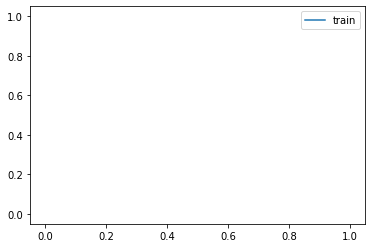

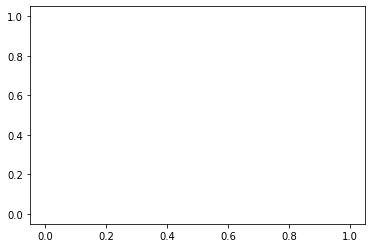

RuntimeError: Expected p_in >= 0 && p_in <= 1 to be true, but got false.  (Could this error message be improved?  If so, please report an enhancement request to PyTorch.)

In [4]:
train_data=torchvision.datasets.MNIST('../data', train=True, download=False,transform=torchvision.transforms.ToTensor())
train_data_list=[]
for x,y in train_data:
    train_data_list.append(np.rint(x))
vae_model = vae(opt).to(opt['device'])
loss_list=[]
test_list=[]
lr_list=[]
for epoch in range(0,1000):
#     if epoch>30:
#         vae_model.optimizer = AGD(vae_model.params, f_star=30,lamb=2.,eta=1.0)

#     if epoch>120:
#         vae_model.optimizer = AGD(vae_model.params, f_star=0,lamb=2.,eta=0.1)
    for i in range(0,100):
        index=np.random.choice(1000,1000)
        batch_data_list=[train_data_list[i] for i in index]
        batch_data=torch.stack(batch_data_list).view(-1,784).to(opt['device'])
        vae_model.optimizer.zero_grad()
        loss = vae_model.loss(batch_data)
        loss.backward()
#         vae_model.optimizer.step()
        _,lr=vae_model.optimizer.step(loss)
#     with torch.no_grad():
#         test_loss=vae_model.loss(test_tensor)
#     test_list.append(test_loss.item())
    loss_list.append(loss.item())
    lr_list.append(-lr)

    if epoch%1==0 and epoch!=0:
        print('epoch',epoch)
        print('loss',loss.item())
        plt.plot(loss_list,label='train')
#         plt.plot(test_list,label='test')
        plt.legend()
        plt.show()
        
        plt.plot(lr_list)
        plt.show()
        
        x_sample=vae_model.sample()
        show_many(x_sample,10)
#         torch.save(vae_model.state_dict(), './model_save/binary_vae.pth')

In [ ]:
print(loss_list)

In [ ]:
adam_list=[193.92770385742188, 148.47991943359375, 127.4101333618164, 106.05278778076172, 89.89850616455078, 76.25437927246094, 66.5630111694336, 56.82843780517578, 52.110843658447266, 161.95359802246094, 70.44442749023438, 47.7762565612793, 38.78557205200195, 35.40535354614258, 33.28783416748047, 31.846569061279297, 30.882841110229492, 29.6651668548584, 29.821638107299805, 29.97037696838379]

In [ ]:
adp_list=[296.07421875, 279.4053649902344, 289.00775146484375, 257.3891906738281, 221.60606384277344, 210.6116180419922, 192.2322235107422, 193.0423126220703, 176.72889709472656, 161.51605224609375, 160.9470977783203, 156.37876892089844, 159.46141052246094, 158.47836303710938, 153.67193603515625, 123.41472625732422, 118.97792053222656, 122.40232849121094, 139.07736206054688, 112.28130340576172, 134.1543426513672, 113.97319030761719, 113.08992767333984, 142.6894989013672, 122.46269989013672, 108.391357421875, 115.864990234375, 109.69205474853516, 91.05979919433594, 95.69158935546875, 102.07805633544922, 116.15258026123047, 64.09228515625, 169.35020446777344, 73.46353149414062, 76.96578979492188, 63.743507385253906, 57.512290954589844, 51.989646911621094, 48.81515884399414, 42.68445587158203, 41.54779815673828, 38.62696075439453, 42.848487854003906, 41.1719856262207, 33.70945358276367, 39.96569061279297, 33.142005920410156, 32.40340042114258, 32.84163284301758, 32.05373764038086, 31.77777671813965, 31.138782501220703, 31.009737014770508, 30.48401641845703, 30.63330841064453, 30.315898895263672, 30.147686004638672, 30.100234985351562, 30.100046157836914, 29.952239990234375, 30.219024658203125, 30.03301429748535, 30.161209106445312, 30.10397720336914, 30.244522094726562, 29.966718673706055, 30.035179138183594, 30.16781997680664, 30.08378791809082, 30.103790283203125, 30.10944366455078, 29.911495208740234, 30.073665618896484, 29.988542556762695, 30.064983367919922, 29.91577911376953, 29.973901748657227, 30.017698287963867, 30.007280349731445, 30.17346954345703, 30.05635643005371, 30.016050338745117, 30.001049041748047, 29.85213279724121, 29.878780364990234, 29.92803192138672, 30.13063621520996, 30.036123275756836, 29.981964111328125, 30.547008514404297, 29.931833267211914, 29.923734664916992, 29.991880416870117, 30.069429397583008, 29.869112014770508, 29.95294952392578, 30.150188446044922, 30.091243743896484, 30.110118865966797, 29.972692489624023, 30.02884292602539, 29.923107147216797, 29.951457977294922, 30.009401321411133, 29.842741012573242, 29.949697494506836, 30.21674919128418, 30.19983673095703, 29.89746856689453, 29.76673698425293, 30.22359848022461, 30.07140350341797, 29.87256622314453, 29.843290328979492, 30.05533218383789, 29.838476181030273, 30.20238494873047, 30.08446502685547, 30.024200439453125, 30.04332160949707, 30.195241928100586, 29.968223571777344, 29.840349197387695, 29.96337127685547, 30.063291549682617, 29.936826705932617, 30.132482528686523, 30.101627349853516, 29.883663177490234, 30.073591232299805, 29.95235824584961, 30.061216354370117, 30.22165298461914, 29.76812171936035, 29.982711791992188, 30.126941680908203, 29.9021053314209, 30.014984130859375, 29.986177444458008, 29.948081970214844, 30.15109634399414, 30.04885482788086, 29.993303298950195, 30.165966033935547, 29.924039840698242, 30.034543991088867, 30.062517166137695, 29.855417251586914, 29.955495834350586, 29.92738914489746, 30.23851776123047, 30.029329299926758, 29.9188175201416, 30.10393714904785, 30.193340301513672, 29.826995849609375, 30.061725616455078, 30.017139434814453, 29.824356079101562, 29.875978469848633, 30.070219039916992, 29.93905258178711, 30.166017532348633, 30.215843200683594, 29.899152755737305, 30.191530227661133, 29.864551544189453, 30.103801727294922, 29.915361404418945, 29.854097366333008, 29.98419189453125, 29.89899444580078, 29.952226638793945, 29.935993194580078, 30.028196334838867, 30.06938362121582, 30.185077667236328, 29.847211837768555, 30.04500389099121, 29.970491409301758, 29.907848358154297, 29.8649845123291, 30.073482513427734, 30.01039695739746, 29.975849151611328, 29.79926300048828, 30.136672973632812, 30.037355422973633, 30.020334243774414, 30.057830810546875, 30.00153350830078, 29.88374900817871, 29.766036987304688, 30.06767463684082, 30.16499137878418, 30.053577423095703, 29.977651596069336, 30.144062042236328, 30.057355880737305, 30.020254135131836, 29.985980987548828, 30.13121795654297, 29.936525344848633, 30.074066162109375, 30.308425903320312, 30.01805877685547, 30.03588104248047, 30.029010772705078, 29.74436378479004, 29.981746673583984, 29.848583221435547, 30.140796661376953, 29.879911422729492, 29.98508071899414, 30.013595581054688]

In [ ]:
plt.plot(adam_list)
plt.plot(adp_list)
plt.plot(loss_list)
plt.ylim(0,300)
plt.show()

In [ ]:
test_data_t=torch.stack(test_data_list[0:1]).reshape(-1,784)
print(vae_model.loss(test_data_t.to(opt['device'])))